# Baseline Models

We will develop the baseline neural network model (one hidden layer, 3-node softmax output) for comparisons for later architectures.

In [104]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [105]:
# Reading in Data
data_path = 'data/merged.csv'
data = pd.read_csv(data_path)

In [131]:
# Function to convert data to classification
def label_type(row):
    """ Converts continuous label to categorical label
    """
    if row['scaled_effect'] < .9:
        return('Deleterious')
    elif row['scaled_effect'] > 1.1:
        return('Beneficial')
    else:
        return('Neutral')

In [132]:
# Change to classification
data['type'] = data.apply(lambda row: label_type(row), axis = 1)
data_final = data.drop(['scaled_effect'], axis=1)

In [133]:
# LOPO Splitting
def train_test_split(protein, curr_data):
    train_data = curr_data[curr_data.protein != protein].drop(['protein', 'pdb', 'resnum'], axis=1)
    test_data = curr_data[curr_data.protein == protein].drop(['protein', 'pdb', 'resnum'], axis=1)
    
    y_train = train_data.type
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_y_train = encoder.transform(y_train)
    y_train_oh = np_utils.to_categorical(encoded_y_train)
    
    scaler_train = StandardScaler()
    x_train = train_data.drop(['type'], axis=1)
    x_columns = x_train.columns
    x_train = scaler_train.fit_transform(x_train)
    x_train = pd.DataFrame(x_train, columns=x_columns)
    
    y_test = test_data.type
    encoder = LabelEncoder()
    encoder.fit(y_test)
    encoded_y_test = encoder.transform(y_test)
    y_test_oh = np_utils.to_categorical(encoded_y_test)
    
    scaler_test = StandardScaler()
    x_test = test_data.drop(['type'], axis=1)
    x_test = scaler_test.fit_transform(x_test)
    x_test = pd.DataFrame(x_test, columns=x_columns)

    return x_train, y_train_oh, x_test, y_test_oh

In [134]:
# Baseline Model
def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim = 108, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(3, activation='softmax'))
    opt = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return(model)

In [135]:
# Baseline Analysis
def baseline(protein):
    # Split Training Data based on Protein
    x_train, y_train, x_test, y_test = train_test_split(protein, data_final)
    
    # Build Model
    # 40 epochs based on initial runs and graphing of loss over time.
    estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=64, verbose=1)
    estimator.fit(x_train, y_train, verbose=1)
    
    # Generate Analysis Characteristics
    probs = estimator.predict_proba(x_test)
    predictions = estimator.predict(x_test)
    precision = precision_score(np.argmax(y_test,1), predictions, average="macro", zero_division=0)
    score = estimator.score(x_test, y_test)

    print('Accuracy: {}'.format(score))
    print('Precision: {}'.format(precision))
    
    # Plotting Confusion Matrices
    cmatrix = confusion_matrix(np.argmax(y_test,1), predictions)
    fig, ax = plt.subplots()
    sns.heatmap(cmatrix, xticklabels = ['Beneficial', 'Deleterious', 'Neutral'], yticklabels = ['Beneficial', 'Deleterious', 'Neutral'])
    ax.set_title('{}'.format(protein))
    plt.savefig('img/baseline-cmatrix/' + protein + '-baseline-cmatrix.png', dpi=300)

Epoch 1/20
24441/24441 [==============================] - 1s 53us/step - loss: 1.2024 - accuracy: 0.6920
Epoch 2/20
24441/24441 [==============================] - 1s 45us/step - loss: 0.7615 - accuracy: 0.7071
Epoch 3/20
24441/24441 [==============================] - 1s 46us/step - loss: 0.7285 - accuracy: 0.7127
Epoch 4/20
24441/24441 [==============================] - 1s 45us/step - loss: 0.7213 - accuracy: 0.7149
Epoch 5/20
24441/24441 [==============================] - 1s 50us/step - loss: 0.7143 - accuracy: 0.7163
Epoch 6/20
24441/24441 [==============================] - 1s 51us/step - loss: 0.7118 - accuracy: 0.7185
Epoch 7/20
24441/24441 [==============================] - 1s 46us/step - loss: 0.7066 - accuracy: 0.7199
Epoch 8/20
24441/24441 [==============================] - 1s 49us/step - loss: 0.7046 - accuracy: 0.7210
Epoch 9/20
24441/24441 [==============================] - 1s 48us/step - loss: 0.7006 - accuracy: 0.7222
Epoch 10/20
24441/24441 [==============================

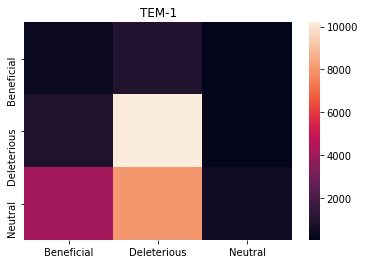

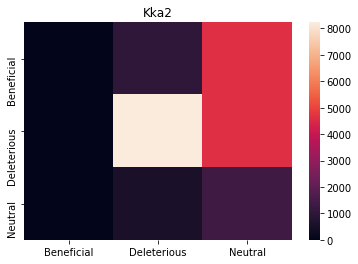

In [137]:
# Only Run TEM-1 and Kka2 because other proteins have too little data for neural network training
baseline('TEM-1')
baseline('Kka2')